#### Final Project: Rick & Morty analysis

# Phase 3: Exploring Data

In [1]:
# imports
import pandas as pd
import numpy as np
import ast
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load files

In [249]:
df_characters = pd.read_csv("df_characters_with_attr_and_communities.csv")
df_characters.head()

Name                                          Hyperlink  \
0    Abandoned Jerrys  https://rickandmorty.fandom.com/wiki/Abandoned...   
1  Abrodolph Lincoler  https://rickandmorty.fandom.com/wiki/Abrodolph...   
2                Adam          https://rickandmorty.fandom.com/wiki/Adam   
3    Adjudicator Rick  https://rickandmorty.fandom.com/wiki/Adjudicat...   
4           Afro Rick     https://rickandmorty.fandom.com/wiki/Afro_Rick   

                                           Relations   Species  \
0                                    ['Jerry Smith']     Human   
1   ['Rick Sanchez', 'Brad', 'Morty Smith', 'Nancy']     Human   
2                                                 []  Humanoid   
3                                     ['Evil Morty']     Human   
4  ['Rick Sanchez', 'Morty Smith', 'Council of Ri...     Human   

             Origin      Gender   Status  in_degree  out_degree  community  
0           unknown  Genderless  unknown        0.0         1.0        0.0  
1           unknown  Genderless  unknown        5.0         4.0       10.0  
2  Narnia Dimension        Male     Dead        NaN         NaN        NaN  
3           unknown        Male     Dead        1.0         1.0        2.0  
4           unknown  Genderless  unknown        2.0         7.0        2.0

# Clean/populate characters dataframe

### Global changes

In [250]:
# remove all characters from the Comic
comic_character_to_remove = {}
for anIndex, aRow in df_characters.iterrows():
    character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read() 
    if '[[Category:Comic Characters]]' in character_page:
        comic_character_to_remove[aRow.Name]=anIndex
print("We found {} characters from the comic universe".format(len(comic_character_to_remove.keys())))
df_characters = df_characters.drop(comic_character_to_remove.values(), axis=0)

# remove Fortnite characters
fornite_counter = 0
for anIndex, aRow in df_characters.iterrows():
    character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read()
    if '[[Category:Fortnite]]' in character_page:
        df_characters = df_characters.drop(anIndex, axis=0)
        fornite_counter +=1
print("We found {} characters from Fortnite".format(fornite_counter))

We found 27 characters from the comic universe
We found 4 characters from Fortnite


### Populate gender

In [251]:
df_characters.Gender.value_counts()

Male          250
Genderless    211
Female         53
unknown         1
Name: Gender, dtype: int64

In [252]:
# add Gender values

# Cynthia has unknown gender = change it to Female
cynthia_index = df_characters[df_characters.Name == 'Cynthia'].index[0]
df_characters.loc[cynthia_index, 'Gender']='Female'

# collect gender value from character Wiki page
genders_to_add = {}
gender_names_list = []
for anIndex, aRow in df_characters.iterrows():
    character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read() 
    if ('[[Category:Male Characters]]' in character_page) and ('[[Category:Female Characters]]' not in character_page):
        # male
        genders_to_add[anIndex]='Male'
        gender_names_list.append(aRow.Name)
    elif ('[[Category:Female Characters]]' in character_page) and ('[[Category:Male Characters]]' not in character_page):
        # female
        genders_to_add[anIndex]='Female'
        gender_names_list.append(aRow.Name)
    elif '[[Category:Female Characters]]' in character_page and '[[Category:Male Characters]]' in character_page :
        # both genders found!!
        genders_to_add[anIndex]='Both'
        gender_names_list.append(aRow.Name)
    # if the gender is not found: do nothing

# check differences then fix them... if we can!
for k,v in genders_to_add.items():
    if df_characters.loc[k,'Gender'] != 'Genderless' and v != df_characters.loc[k,'Gender']:
        print('Difference:',df_characters.loc[k,'Name'],v,df_characters.loc[k,'Gender'])
# >>> we found no difference

# study both genders characters
for key in [k for k,v in genders_to_add.items() if v == 'Both']:
    print('Classified with Both Genders: ', df_characters.loc[key,'Name'])
# >>> Dipper and Mabel Mortys &  Tina-Teers
# Tina-Teers: it's a group of superheroes, we can remove this row
tineteers_index = df_characters[df_characters.Name == 'Tina-Teers'].index[0]
df_characters = df_characters.drop([tineteers_index], axis=0)
# Dipper and Mabel Mortys: it's a duo of two characters, let's keep "Both" as Gender

# replace genders in detected cases
for anIndex, aRow in df_characters.iterrows():
    if aRow.Gender == 'Genderless' and anIndex in genders_to_add.keys():
        df_characters.loc[anIndex, 'Gender'] = genders_to_add[anIndex]

# let's populate manually the 89 remaining 'Genderless' characters
df_genderless_to_populate = pd.read_csv("df_characters_genderless_to_populate.csv")
for _, aRow in df_genderless_to_populate.iterrows():
    if aRow.Name in df_characters.Name:
        anIndex = df_characters[df_characters.Name == aRow.Name].index[0]
        df_characters.loc[anIndex, 'Gender'] = aRow.Gender

# thus we are sure that the remaining Genderless are actually Genderless (people, machine, alien)

Classified with Both Genders:  Dipper and Mabel Mortys
Classified with Both Genders:  Tina-Teers


In [253]:
df_characters.Gender.value_counts()

Male          342
Female         86
Genderless     85
Both            1
Name: Gender, dtype: int64

## Populate Species

In [254]:
print('unknown=',len(df_characters[df_characters.Species == 'unknown']))

unknown= 147


In [255]:
species_to_populate = {}
species_to_check = {}
all_species_wik_categories = ['Category:Alien Parasite Characters','Category:Aliens','Category:Clones', 'Category:Cyborgs','Category:Humans','Category:Mythologs','Category:Robots','Category:Vampires']
for anIndex, aRow in df_characters.iterrows():
    if aRow.Species == 'unknown':
        character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read() 
        species_name = ''
        for aSpecies in all_species_wik_categories:
            if aSpecies in character_page:
                if aSpecies == 'Category:Alien Parasite Characters':
                    species_name = 'Parasite'
                else:
                    species_name = aSpecies.split('Category:')[1][:-1]
                species_to_populate[anIndex]=species_name
        if species_name == '':
            # try to search a 'Species' attribute in the page
            if '|species=' in character_page:
                species_name = character_page.split('|species=')[1].split('\n')[0]
                if '|' in species_name:
                    species_name = species_name.split('|')[0]
                species_to_check[anIndex] = species_name

# check found attributes as Species
# replace CHUD by Chud
species_to_check = {k:(v if v != 'CHUD' else 'Chud') for k,v in species_to_check.items() }
# replace 'CHUD/Human Hybrid' by 'Humanoid'
species_to_check[389]='Humanoid'
# replace ' Hologram (Formerly)<br> Mutated Human' by 'Humanoid'
species_to_check[205]='Humanoid'
# add to species_to_populate
for k,v in species_to_check.items():
    species_to_populate[k] = v

# populate unknown
for k,v in species_to_populate.items():
    df_characters.loc[k, 'Species'] = v
    
# manually populate the 53 remaining unknown species
#df_characters[df_characters.Species == 'unknown'][['Name','Species','Hyperlink']].to_csv('df_characters_species_to_populate.csv', index=False)
df_characters_species_to_populate = pd.read_csv('df_characters_species_to_populate.csv')
for _, aRow in df_characters_species_to_populate.iterrows():
    anIndex = df_characters[df_characters.Name == aRow.Name].index[0]
    df_characters.loc[anIndex, 'Species'] = aRow.Species
    
# thus we are sure that the remaining "unknown" have actually an unknown species, because we don't know enough in the series about them

In [256]:
print('unknown=',len(df_characters[df_characters.Species == 'unknown']))

unknown= 1


## Populate Status

In [257]:
df_characters.Status.value_counts()

unknown    236
Alive      161
Dead       116
 2.0         1
Name: Status, dtype: int64

In [258]:
# classify unknown Status from Wiki page
status_to_populate = {}
for anIndex, aRow in df_characters.iterrows():
    character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read()
    if '[[Category:Deceased Characters]]' in character_page:
        status_to_populate[anIndex]='Dead'
    else:
        # search attribute in Wiki page
        aStatus = ''
        if '|status =' in character_page:
            aStatus = character_page.split('|status =')[1]
        elif '|status=' in character_page:
            aStatus = character_page.split('|status=')[1]
        if aStatus != '':
            if 'alive' in aStatus[:20].lower() or 'extant' in aStatus[:20].lower() or 'crystalized' in aStatus[:20].lower():
                aStatus = 'Alive'
            elif 'deceased' in aStatus[:20].lower() or 'dead' in aStatus[:20].lower() or 'shut down' in aStatus[:20].lower():
                aStatus = 'Dead'
            #elif 'unknown' in aStatus[:20].lower():
                #aStatus = 'Unknown'
        if aStatus in ['Alive','Dead']:
            status_to_populate[anIndex]=aStatus

In [259]:
# difference between Wiki and API (existing dataframe): let's trust the Wiki (Jesus Christ committed suicide, and all other characters are dead)
for k,v in status_to_populate.items():
    if df_characters.loc[k,'Status'] != v and df_characters.loc[k,'Status'] != 'unknown':
        print(df_characters.loc[k,'Name'],df_characters.loc[k,'Status'],v)

Jesus Christ Alive Dead
Squeeb Alive Dead
Trandor Alive Dead
Cynthia  2.0 Dead


In [260]:
# populate unknown
for k,v in status_to_populate.items():
    df_characters.loc[k, 'Status'] = v

In [261]:
df_characters.Status.value_counts()

Alive      241
Dead       164
unknown    109
Name: Status, dtype: int64

## Populate Origin

In [262]:
print('unknown=',len(df_characters[df_characters.Origin == 'unknown']))

unknown= 347


In [263]:
# classify unknown Status from Wiki page
origin_to_populate = {}
for anIndex, aRow in df_characters.iterrows():
    if aRow.Origin == 'unknown':
        character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read()
        anOrigin = ''
        if '|origin' in character_page:
            anOrigin = character_page.split('|origin')[1]
            if '|' in anOrigin:
                anOrigin = anOrigin.split('|')[0]
            elif '}' in anOrigin:
                anOrigin = anOrigin.split('}')[0]
            if 'unknown' not in anOrigin.lower():
                anOrigin = anOrigin.replace('\n','')
                anOrigin = anOrigin.replace('[[','')
                anOrigin = anOrigin.replace(']]','')
                anOrigin = anOrigin.replace(' = ','')
                anOrigin = anOrigin.replace('=','')
                anOrigin = anOrigin.strip()
                if anOrigin != '':
                    origin_to_populate[anIndex]=anOrigin

In [264]:
# populate known origins
unique_origins_list = list(df_characters.Origin.unique())
unique_origins = dict(zip([s.lower() for s in unique_origins_list], unique_origins_list))
added_k = []
for k,v in origin_to_populate.items():
    if v.lower() in unique_origins.keys():
        #df_characters.loc[k,'Origin'] = unique_origins[v.lower()]
        added_k.append(k)
        print('Added:',df_characters.loc[k,'Name'], 'in:',unique_origins[v.lower()])
for k in added_k:
    del origin_to_populate[k]

Added: Centaur in: Mr. Goldenfold's dream
Added: Helium-Q in: Alphabetrium
Added: Jessica's Grandma in: Earth (Replacement Dimension)
Added: Jodie in: Earth (Replacement Dimension)
Added: Joseph Lipnip in: Earth (Replacement Dimension)
Added: Kiara in: Krootabulon
Added: Morty Smith (Replacement Dimension) in: Earth (Replacement Dimension)
Added: Mrs. Lipnip in: Earth (Replacement Dimension)
Added: Rick Sanchez (Replacement Dimension) in: Earth (Replacement Dimension)
Added: Story Lord in: Story Train
Added: The Little Girl in: Mr. Goldenfold's dream
Added: Water-T in: Alphabetrium


In [265]:
# manually study the remaining cases

# df_characters_origins_to_populate = df_characters.loc[origin_to_populate.keys(),['Name','Origin',]]
# df_characters_origins_to_populate['Found']=origin_to_populate.values()
# df_characters_origins_to_populate['Hyperlink']=df_characters.loc[origin_to_populate.keys(),'Hyperlink']
# df_characters_origins_to_populate.to_csv('df_characters_origins_to_populate.csv',index=False)
# df_characters_origins_to_populate.head()

df_characters_origins_to_populate = pd.read_csv('df_characters_origins_to_populate.csv')
for _, aRow in df_characters_origins_to_populate.iterrows():
    anIndex = df_characters[df_characters.Name == aRow.Name].index[0]
    df_characters.loc[anIndex, 'Origin'] = aRow.Origin

In [266]:
# fix minor issues in typo
for anIndex, aRow in df_characters[df_characters.Origin == 'Earth (Replacement dimension)'].iterrows():
    df_characters.loc[anIndex, 'Origin']='Earth (Replacement Dimension)'
for anIndex, aRow in df_characters[df_characters.Origin == 'Microverse'].iterrows():
    df_characters.loc[anIndex, 'Origin']="Rick's Battery Microverse"
for anIndex, aRow in df_characters[df_characters.Origin == 'Zigerion (planet)Genderless'].iterrows():
    df_characters.loc[anIndex, 'Origin']='Zigerion'

In [267]:
print('unknown=',len(df_characters[df_characters.Origin == 'unknown']))

unknown= 312


## Explort final dataframe

In [268]:
#df_characters.drop(['in_degree','out_degree','community'],axis=1).to_csv("RaM_characters_wRelationsAndAttributes_final.csv", index=False)

## Fixing relations

In [269]:
# fix relations since we're dropping characters
df_characters = pd.read_csv("RaM_characters_wRelationsAndAttributes_final.csv")
for anIndex, aRow in df_characters.iterrows():
    char_relations = ast.literal_eval(aRow.Relations)
    for aChar in char_relations:
        if aChar not in list(df_characters.Name):
            char_relations.remove(aChar)
    df_characters.loc[anIndex, 'Relations'] = char_relations
df_characters.to_csv("RaM_characters_wRelationsAndAttributes_final.csv",index=False)

# Build graph

In [2]:
df_characters = pd.read_csv("RaM_characters_wRelationsAndAttributes_final.csv")
df_characters.head()

Name                                          Hyperlink  \
0    Abandoned Jerrys  https://rickandmorty.fandom.com/wiki/Abandoned...   
1  Abrodolph Lincoler  https://rickandmorty.fandom.com/wiki/Abrodolph...   
2                Adam          https://rickandmorty.fandom.com/wiki/Adam   
3    Adjudicator Rick  https://rickandmorty.fandom.com/wiki/Adjudicat...   
4           Afro Rick     https://rickandmorty.fandom.com/wiki/Afro_Rick   

                                           Relations   Species  \
0                                    ['Jerry Smith']     Human   
1   ['Rick Sanchez', 'Brad', 'Morty Smith', 'Nancy']     Human   
2                                                 []  Humanoid   
3                                     ['Evil Morty']     Human   
4  ['Rick Sanchez', 'Morty Smith', 'Council of Ri...     Human   

                   Origin Gender   Status  
0                   Earth   Male    Alive  
1                 unknown   Male  unknown  
2        Narnia Dimension   Male     Dead  
3                 unknown   Male     Dead  
4  Earth (Dimension E-33)   Male    Alive

In [3]:
def add_node(row, aGraph):
    """ Add the node given in row to global network """
    aGraph.add_node(row.Name, species=row.Species, origin=row.Origin, gender = row.Gender, status = row.Status)

def add_edges(row, aGraph):
    """ Add all edges which concern given character in row"""
    char_name = row.Name
    char_relations = ast.literal_eval(row.Relations)
    for aTargetRelation in char_relations:
        aGraph.add_edge(char_name,aTargetRelation)

In [4]:
# Create the associate graph with all attributes
G = nx.DiGraph()
_ = df_characters.apply(add_node, args=(G,), axis=1)
_ = df_characters.apply(add_edges, args=(G,), axis=1)

# Extract the Giant Connected Component, GCC
GCC = nx.weakly_connected_components(G)
GCC = list(GCC)
GCC.sort(key=len)
concerned_nodes = GCC[-1]

GCC = G.subgraph(concerned_nodes).copy()

# make G undirected
GU = G.to_undirected()

# Basic stats & attributes study

## Main characteristics

In [5]:
nb_edges, nb_nodes = G.number_of_edges(), G.number_of_nodes()

print("We have {} nodes, and {} edges".format(nb_nodes, nb_edges))

We have 514 nodes, and 1891 edges


## Attributes distributions

Gender = {'Male': 342, 'Female': 86, 'Genderless': 85, 'Both': 1}


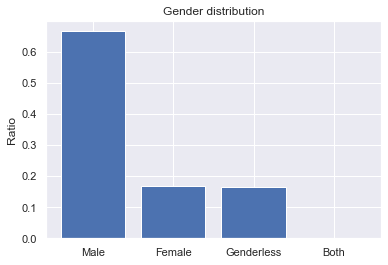

In [6]:
# plot distribution of Gender
gender_dict = dict(df_characters.Gender.value_counts())
print(f"Gender = {gender_dict}")
plt.bar(x=gender_dict.keys(), height=np.array(list(gender_dict.values()))/nb_nodes)
plt.title("Gender distribution")
plt.ylabel('Ratio')
plt.show()

In [171]:
342/(342+86+86)

0.6653696498054474

In [172]:
86/(342+86+86)

0.16731517509727625

See later for a deeper analysis of gender equity in RaM! Nice results!!

Status = {'Alive': 241, 'Dead': 164, 'unknown': 109}


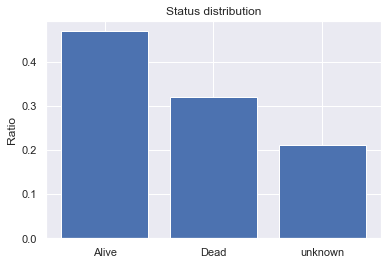

In [7]:
# plot status distribution
status_dict = dict(df_characters.Status.value_counts())
print(f"Status = {status_dict}")
plt.bar(x=status_dict.keys(), height=np.array(list(status_dict.values()))/nb_nodes)
plt.title("Status distribution")
plt.ylabel('Ratio')
plt.show()

To what extent is Rick responsible of those stats?

In [8]:
# add if [[Category:Killed by Rick]] appear in description
isKilledByRick = []
for anIndex, aRow in df_characters.iterrows():
    character_page = open('character_pages/'+aRow.Name+'.txt', encoding="utf-8").read()
    if '[[Category:Killed by Rick]]' in character_page:
        isKilledByRick.append(True)
    else:
        isKilledByRick.append(False)
df_characters['isKilledByRick']=isKilledByRick

In [9]:
# check that we don't find a character alive and killed by Rick! => we just have Memory Parasites
df_characters[(df_characters.isKilledByRick==True) & (df_characters.Status != 'Dead')]

Name                                          Hyperlink  \
269  Memory Parasites  https://rickandmorty.fandom.com/wiki/Memory_Pa...   

                                             Relations Species   Origin  \
269  ['Steven Smith', 'Cousin Nicky', 'Mr. Beaurega...   Alien  unknown   

         Gender   Status  isKilledByRick  
269  Genderless  unknown            True

In [10]:
# let's found the ratio which is interesting to us
ratio_is_killed_by_rick = len(df_characters[df_characters.isKilledByRick==True])/len(df_characters[df_characters.Status == 'Dead'])
print("Rick killed {} % of found dead people".format(round(ratio_is_killed_by_rick*100,2)))

Rick killed 39.02 % of found dead people


Species = {'Human': 224, 'Alien': 143, 'Humanoid': 45, 'Mythological Creature': 23, 'Robot': 18, 'Animal': 14, 'Cronenberg': 6, 'Poopybutthole': 6, 'Bird Person': 3, 'Giant': 2, 'Larva': 2, 'Space Sperm': 2, 'Gromflomite': 2, 'Parasite': 2, 'Monster': 2, 'Chud': 2, 'Dream Human': 1, 'Bread': 1, 'Divine Entity': 1, 'Shrimp': 1, 'Scary': 1, 'unknown': 1, 'Sentient Memory (Human appearance)': 1, 'Switchblade': 1, 'Sentient planet': 1, 'Pickle': 1, 'Demon': 1, 'Krootabulan': 1, 'Crittendians': 1, 'Alphabetrian': 1, 'Living Scarecrow': 1, 'Vampire': 1, 'Human Part': 1, 'Zigerion': 1}


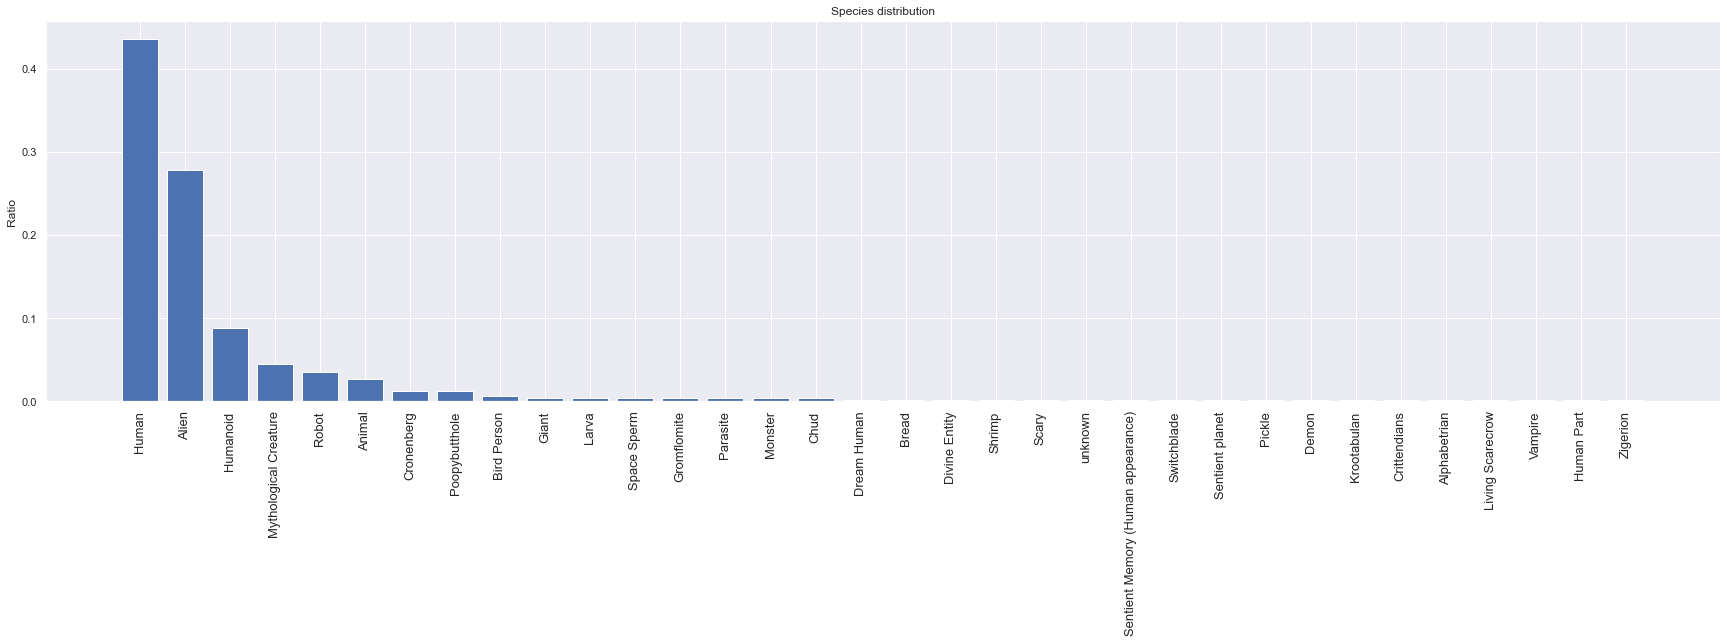

In [11]:
# plot species distribution
species_dict = dict(df_characters.Species.value_counts())
print(f"Species = {species_dict}")
plt.figure(figsize=(30,7))
plt.bar(x=species_dict.keys(), height=np.array(list(species_dict.values()))/nb_nodes)
plt.title("Species distribution")
plt.ylabel('Ratio')
plt.xticks(rotation=90, size=13)
plt.show()

Origin = {'unknown': 312, 'Earth (Replacement Dimension)': 55, 'Earth (C-137)': 25, 'Post-Apocalyptic Earth': 8, 'Nuptia 4': 7, 'Earth (C-500A)': 6, "Unity's Planet": 5, 'Narnia Dimension': 4, 'Resort Planet': 4, 'The Citadel': 4, 'Purge Planet': 4, "Mr. Goldenfold's dream": 4, 'Fantasy World': 3, 'Cronenberg Earth': 3, 'Gaia': 3, 'Zigerion': 3, 'Roy: A Life Well Lived': 2, 'Earth (Cyclops)': 2, 'Ricks’s Story': 2, 'Morty': 2, 'Gazorpazorp': 2, 'Gromflom Prime': 2, 'Mount Olympus': 2, "Rick's Battery Microverse": 2, 'Story Train': 2, 'Detoxifier': 2, 'Earth (Giant Telepathic Spiders Dimension)': 2, 'Alphabetrium': 2, 'Pluto': 2, "Zeep Xanflorp's Miniverse": 2, 'The Garage': 1, 'Elemental Rings': 1, 'Interdimensional Cable': 1, 'Earth': 1, 'Earth (Shrimp Universe)': 1, 'Rick and Two Crows Planet': 1, 'Earth (Dimension D-99)': 1, 'Earth (K-22)': 1, 'Mr. Meeseeks Box': 1, 'Planet Squanch': 1, 'Krootabulon': 1, 'Trunk World': 1, 'Plitzville Montana': 1, 'Earth (Wasp Dimension)': 1, 'Bird W

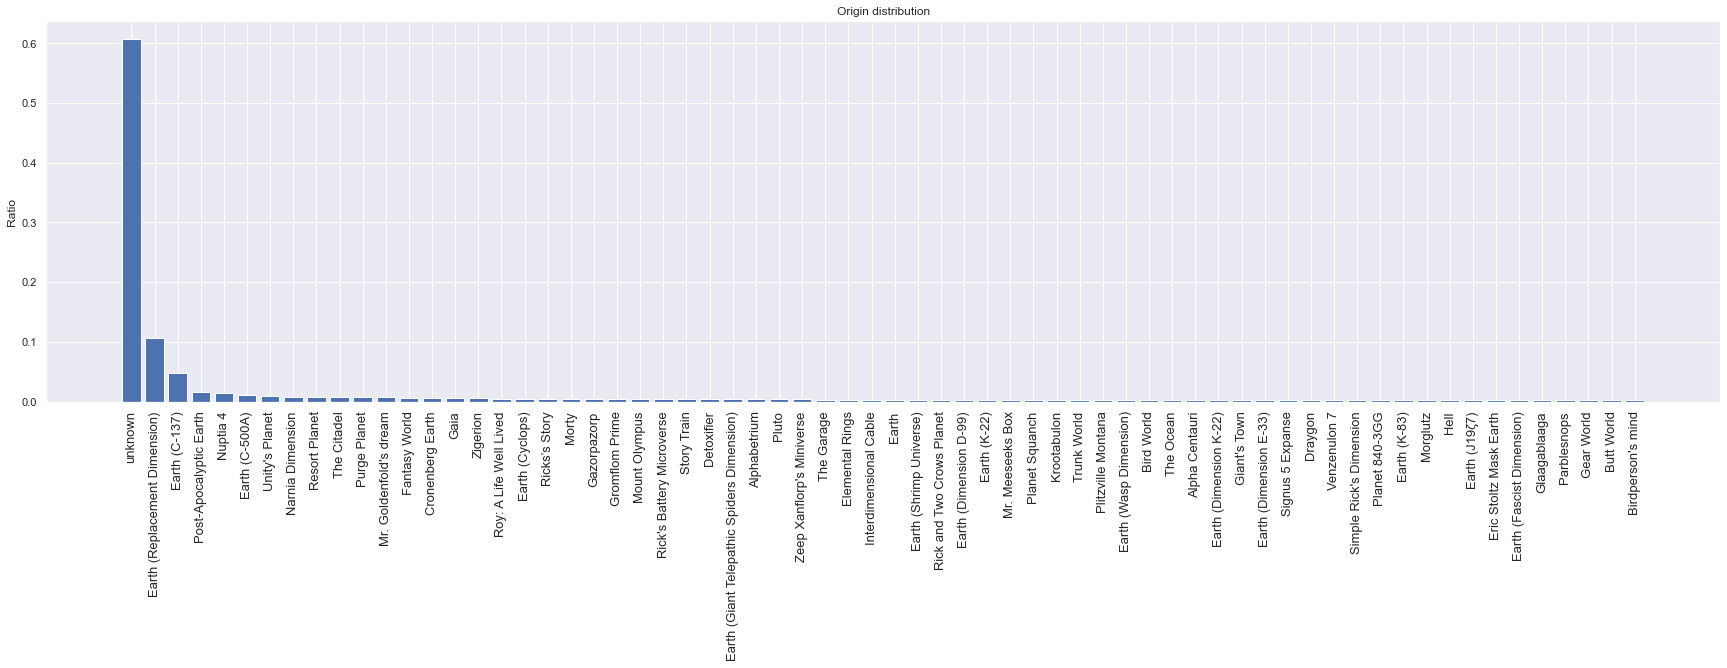

In [12]:
# plot origin distribution
origin_dict = dict(df_characters.Origin.value_counts())
print(f"Origin = {origin_dict}")
plt.figure(figsize=(30,7))
plt.bar(x=origin_dict.keys(), height=np.array(list(origin_dict.values()))/nb_nodes)
plt.title("Origin distribution")
plt.ylabel('Ratio')
plt.xticks(rotation=90, size=13)
plt.show()

### Focus on female characters: study on gender equity effort (let's see that later !!! it's so interesting!!)

https://bleedingcool.com/tv/mansplaining-the-bechdel-test-to-rick-and-morty-fans/
https://www.inverse.com/entertainment/rick-morty-bechdel-test-joke
https://www.youtube.com/watch?v=LsNHAeRZQL4
https://screenrant.com/rick-morty-season-5-female-problem-sexism-story-fix/

In [175]:
def getEpisodeDenomination(S_nb,E_nb):
    S_nb,E_nb=str(S_nb),str(E_nb)
    if len(str(E_nb))==1:
        E_nb = '0'+str(E_nb)
    return "S0{}E{}".format(S_nb, E_nb)

In [13]:
df_episodes = pd.read_csv("RaM_episodes.csv")
df_episodes.head()

Title                                          Hyperlink  \
0                   Pilot         https://rickandmorty.fandom.com/wiki/Pilot   
1           Lawnmower Dog  https://rickandmorty.fandom.com/wiki/Lawnmower...   
2            Anatomy Park  https://rickandmorty.fandom.com/wiki/Anatomy_P...   
3  M. Night Shaym-Aliens!  https://rickandmorty.fandom.com/wiki/M._Night_...   
4    Meeseeks and Destroy  https://rickandmorty.fandom.com/wiki/Meeseeks_...   

   Season_nb  Episode_nb  hasTranscript  \
0          1           1           True   
1          1           2           True   
2          1           3           True   
3          1           4           True   
4          1           5           True   

                                 Involved_Characters  
0  ['Space Cruiser', 'Jessica', 'Summer Smith (Cr...  
1  ['Jerry Smith (Cronenberged dimension)', 'Mrs....  
2  ['Jerry Smith (Cronenberged dimension)', 'Leon...  
3  ['Rick Sanchez', 'Morty Smith', 'Mr. Goldenfol...  
4  ['Morty Smith', 'Rick Sanchez', 'Mr. Meeseeks'...

In [14]:
# female ratio in episodes
all_characters = dict(G.nodes(data=True))
nb_involved_characters_list = []

female_ratio_dict = {}
for anIndex, aRow in df_episodes.iterrows():
    episode_relations = ast.literal_eval(aRow.Involved_Characters)
    nb_involved_characters_list.append(len(episode_relations))
    female_ratio = sum([1 for char in episode_relations if all_characters[char]['gender']=='Female'])/len(episode_relations)
    female_ratio_dict[anIndex]=female_ratio

df_episodes['Female_Ratio']=list(female_ratio_dict.values())
df_episodes['Nb_Involved_Characters'] = nb_involved_characters_list

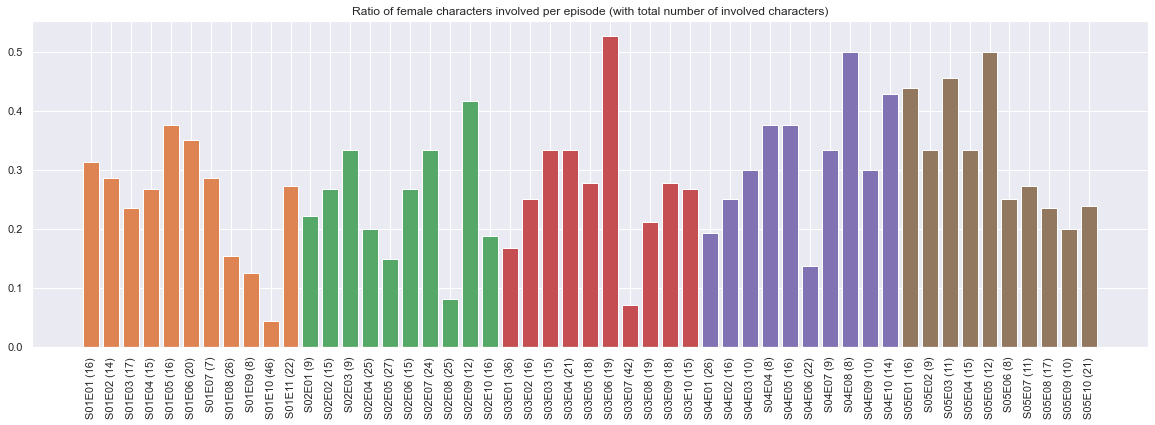

In [217]:
all_colors = sns.color_palette()

plt.figure(figsize=(20,6))
x = female_ratio_dict.keys()
plt.bar(x,female_ratio_dict.values(), color=[all_colors[i] for i in list(df_episodes.Season_nb)])
plt.title('Ratio of female characters involved per episode (with total number of involved characters)')
plt.xticks(list(x),labels=[getEpisodeDenomination(df_episodes.loc[v,'Season_nb'],df_episodes.loc[v,'Episode_nb'])+' ('+str(len(ast.literal_eval(df_episodes.loc[v,'Involved_Characters'])))+')' for v in x], rotation=90)
plt.show()

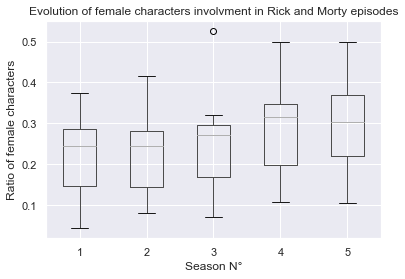

In [16]:
df_episodes.groupby('Season_nb').Female_Ratio.describe().drop('count',axis=1).T.boxplot()
plt.title("Evolution of female characters involvment in Rick and Morty episodes")
plt.xlabel('Season N°')
plt.ylabel("Ratio of female characters")
plt.show()

In [17]:
# compare HITS stats : ok, y a plus de personnages féminins, mais est-ce qu'ils sont importants (hits/hubs score élevé)

## Degree distribution

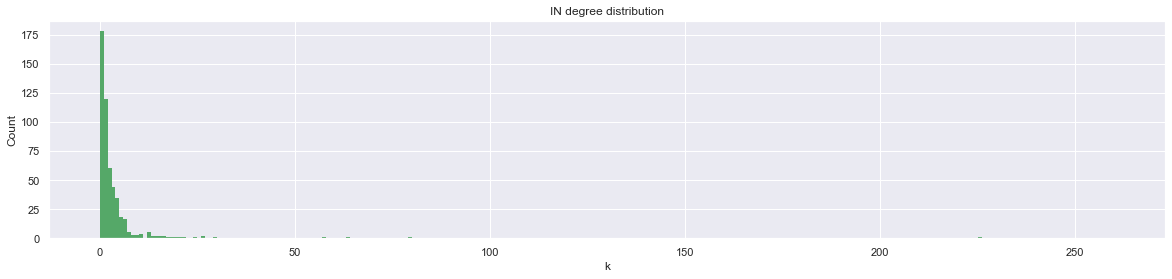

In [18]:
# in degree
plt.figure(figsize=(20,4))
plt.title("IN degree distribution")
plt.xlabel("k")
plt.ylabel('Count')
_ = plt.hist(list(dict(G.in_degree()).values()),bins=range(max(list(dict(G.in_degree()).values()))-min(list(dict(G.in_degree()).values()))),edgecolor='none',color='g')

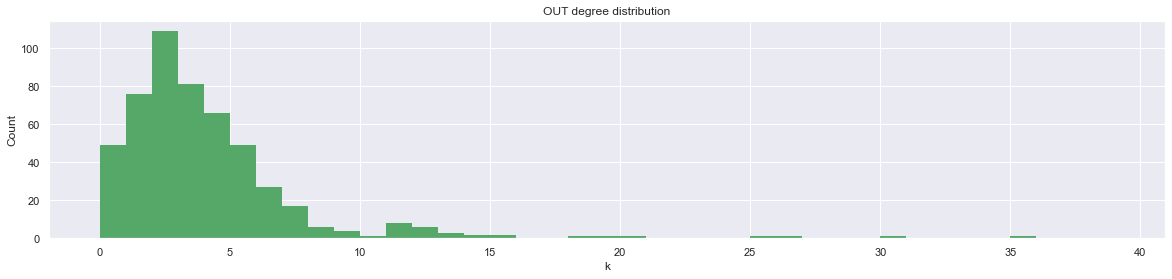

In [19]:
# out degree
plt.figure(figsize=(20,4))
plt.title("OUT degree distribution")
plt.xlabel("k")
plt.ylabel('Count')
_ = plt.hist(list(dict(G.out_degree()).values()),bins=range(max(list(dict(G.out_degree()).values()))-min(list(dict(G.out_degree()).values()))),edgecolor='none',color='g')

In [21]:
# stats

def create_in_out_degree_stats(aGraph):
    aListOfDegreesIn, aListOfDegreesOut = list(dict(aGraph.in_degree()).values()), list(dict(aGraph.out_degree()).values())
    in_degree_stats = pd.DataFrame(np.array(aListOfDegreesIn)).describe().T
    out_degre_stats = pd.DataFrame(np.array(aListOfDegreesOut)).describe().T      
    network_stats = pd.concat([in_degree_stats,out_degre_stats], axis=0)
    network_stats['degreeType']=['in','out']
    return network_stats

create_in_out_degree_stats(G)

count      mean        std  min  25%  50%  75%    max degreeType
0  514.0  3.678988  16.264267  0.0  0.0  1.0  3.0  261.0         in
0  514.0  3.678988   4.063347  0.0  2.0  3.0  5.0   40.0        out

## Plot log-log degreee distributions + compare with BA and WS

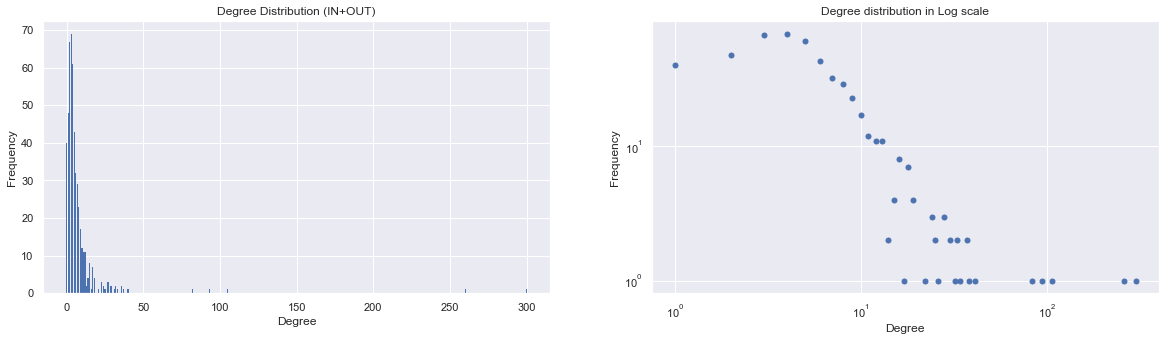

In [22]:
# get log log degree distributions
all_degrees = list(dict(G.degree()).values())
histogram = np.histogram(all_degrees,bins=(max(all_degrees)-min(all_degrees)))

plt.figure(figsize=(20,5))

_ = plt.subplot(121)

plt.title("Degree Distribution (IN+OUT)")
plt.bar(x = histogram[1][:-1], height = histogram[0], edgecolor='none')
plt.xlabel("Degree")
plt.ylabel('Frequency')

_ = plt.subplot(122)

plt.title("Degree distribution in Log scale")
plt.xlabel("Degree")
plt.ylabel('Frequency')
plt.loglog((histogram[1][1:]), (histogram[0]),marker='o',markersize=5, linestyle=' ')

plt.show()

In [107]:
# computing exponent of power law
import powerlaw

in_degree, out_degree = list(dict(G.in_degree()).values()),list(dict(G.out_degree()).values())

in_results, out_results = powerlaw.Fit(in_degree, discrete=True), powerlaw.Fit(out_degree, discrete=True)
in_xmin, out_xmin = int(in_results.find_xmin()),int(out_results.find_xmin())
in_results, out_results = powerlaw.Fit(in_degree, discrete=True, xmin=in_xmin, xmax=max(in_degree)), powerlaw.Fit(out_degree, discrete=True,xmin=out_xmin, xmax=max(out_degree))
indegree_exponent, outdegree_exponent = in_results.alpha, out_results.alpha
indegree_sigma, outdegree_sigma = in_results.sigma, out_results.sigma

print("The exponent of the in-degree distribution is {} (sigma={}).".format(round(indegree_exponent,3),round(indegree_sigma,3)))
print("The exponent of the out-degree distribution is {} (sigma={}).".format(round(outdegree_exponent,3),round(outdegree_sigma,3)))

The exponent of the in-degree distribution is 2.203 (sigma=0.096).
The exponent of the out-degree distribution is 2.866 (sigma=0.132).


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Laurine\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
C:\Users\Laurine\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [129]:
def power_law(x, a, b):
    return a * np.power(x, -b)

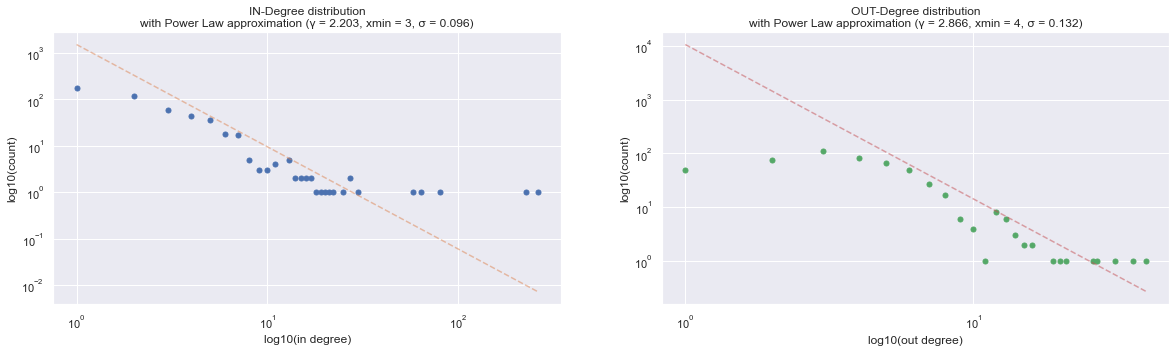

In [170]:
# plot with power law

in_hist, out_hist = np.histogram(in_degree,bins=(max(in_degree)-min(in_degree))) , np.histogram(out_degree,bins=(max(out_degree)-min(out_degree)))

plt.figure(figsize=(20,5))

_ = plt.subplot(121)

plt.title("IN-Degree distribution\nwith Power Law approximation (γ = {}, xmin = {}, σ = {})".format(round(indegree_exponent,3),in_xmin, round(indegree_sigma,3)))
plt.xlabel("log10(in degree)")
plt.ylabel('log10(count)')
plt.loglog((in_hist[1][1:]), (in_hist[0]),marker='o',markersize=5, linestyle=' ')
plt.loglog(
    (in_hist[1][1:]),
    [ power_law(k,sum((in_hist[0]))+10**(in_xmin),indegree_exponent) for k in (in_hist[1][1:])], 
    linestyle='--', 
    alpha=0.5)

_ = plt.subplot(122)

plt.title("OUT-Degree distribution\nwith Power Law approximation (γ = {}, xmin = {}, σ = {})".format(round(outdegree_exponent,3),out_xmin, round(outdegree_sigma,3)))
plt.xlabel("log10(out degree)")
plt.ylabel('log10(count)')
plt.loglog((out_hist[1][1:]), (out_hist[0]),marker='o',markersize=5, linestyle=' ',color='g')
plt.loglog(
    (out_hist[1][1:]),
    [ power_law(k,sum((out_hist[0]))+10**(out_xmin),outdegree_exponent) for k in (out_hist[1][1:])], 
    linestyle='--', 
    alpha=0.5, 
    color='r')

plt.show()

### Community Detection
https://networkx.org/documentation/stable/reference/algorithms/community.html 

In [5]:
import community

In [20]:
def get_partition(attribute, aGraph):
    """ Return a partition of aGraph based on given attribute as a dictionary of community subgraphs """
    nodes_attributes_dic = {k:v[attribute] for k,v in dict(G.nodes(data=True)).items()}
    return get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph)

def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

def get_modularity(communities_dic, aGraph):
    """ Get the modularity M of the partition of a graph aGraph given through the dictionary of subgraphs communities_dic """
    L = aGraph.number_of_edges()
    M = 0
    for _, aCommunityGraph in communities_dic.items():
        Lc = aCommunityGraph.number_of_edges()
        kc = sum(list(dict(aCommunityGraph.degree).values()))
        M += (Lc/L - (kc/(2*L))**2)
    print("Modularity M = {}".format(round(M, 2)))
    return M

In [58]:
list(nx.algorithms.community.centrality.girvan_newman(GU))

[({'Abandoned Jerrys',
   'Abrodolph Lincoler',
   'Adjudicator Rick',
   'Afro Rick',
   'Agent Gribbles',
   'Alan Rails',
   'Albert Einstein',
   'Alexander',
   'Alien Googah',
   'Alien Morty',
   'Alien Rick',
   'Alyson Hannigan',
   'Amfiddians',
   'Amish Cyborg',
   'Annie',
   'Antenna Morty',
   'Antenna Rick',
   'Aqua Morty',
   'Aqua Rick',
   'Arcade Alien',
   'Arm Head Mutant Morty',
   'Armagheadon',
   'Armothy',
   'Arthricia',
   'Artist Morty',
   'Baby Poopybutthole',
   'Baby Wizard',
   'Balthromaw',
   'Bearded Lady',
   'Beebo',
   'Benjamin',
   'Bepisians',
   'Beta-Seven',
   'Beth Sanchez (C-137)',
   'Beth Sanchez (C-500A)',
   "Beth Sanchez (Simple Rick's Dimension)",
   'Beth Smith',
   'Beth Smith (304-X)',
   'Beth Smith (C-132)',
   "Beth Smith (Evil Rick's Target Dimension)",
   "Beth's Mytholog",
   'Big Boobed Waitress',
   'Big Fat Rick',
   'Big Morty',
   "Big Morty's Bodyguard Mortys",
   'Big-Head Morty',
   'Bill (Dog)',
   'Birdperson',


In [34]:
best_partition = community.best_partition(GU)

# For best partition 'Louvain-algorithm' from community (networkx)
print("Partition based best partition with Louvain-algorithm:")
best_partition_subgraphs = get_partition_from_nodes_attributes(best_partition, G)
best_partition_modularity = get_modularity(best_partition_subgraphs, G)
print("Number of communities found: {}".format(len(best_partition_subgraphs)))

Partition based best partition with Louvain-algorithm:
Modularity M = 0.6
Number of communities found: 69


In [40]:
best_partition_char_lists = {k:list(aSubGraph.nodes()) for k,aSubGraph in best_partition_subgraphs.items()}
best_partition_char_lists = dict(sorted(best_partition_char_lists.items(), reverse=True, key=lambda x:len(x[1])))

In [41]:
best_partition_char_lists

{7: ['Blue Footprint Guy',
  'Kathy Ireland',
  'Japheth',
  'Taddy Mason',
  'Morty Smith',
  'Butter Robot',
  'Artist Morty',
  'Michael Denny and the Denny Singers',
  'Xing Ho',
  'Mr. Booby Buyer',
  'Voltamatron',
  'Brad Anderson',
  'Diseases',
  'Diesel Weasel',
  'Armothy',
  'Rick Sanchez (K-22)',
  'Truth Tortoise',
  'Solicitor Rick',
  'Katherine Heffelfinger',
  'Bova',
  'Jodie',
  'Dave',
  'Gobo',
  'Colossus',
  'Purge Planet Ruler',
  'Dale',
  'Lord Henderfinger',
  'Drippy Boy',
  'Morty Smith (K-22)',
  'Coach Feratu',
  'Long Sleeved Morty',
  'General Store Owner',
  'Planetina',
  'Crystallized Morty',
  'Tina-Teers',
  'Alexander',
  "Morty's Girlfriend",
  'Jaguar',
  'Hammerhead Morty (Fortnite)',
  'Arthricia',
  'Roy',
  'Heroin Keith',
  'Phillip Jacobs',
  'Blazen',
  'Cyclops Rick',
  'Annie',
  'Aqua Morty',
  'Doofus Rick',
  'Cyclops Morty',
  'Hoovy',
  'Trunk People',
  'Rick Sanchez (J19α7)',
  'Aqua Rick',
  'Dipper and Mabel Mortys',
  'Concer

In [24]:
import fa2
import matplotlib.cm as cm

In [25]:
# node color list
node_color_list = [cm.get_cmap("tab20")(best_partition[node]) for node in list(G.nodes())]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.42it/s]


BarnesHut Approximation  took  1.36  seconds
Repulsion forces  took  10.99  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds


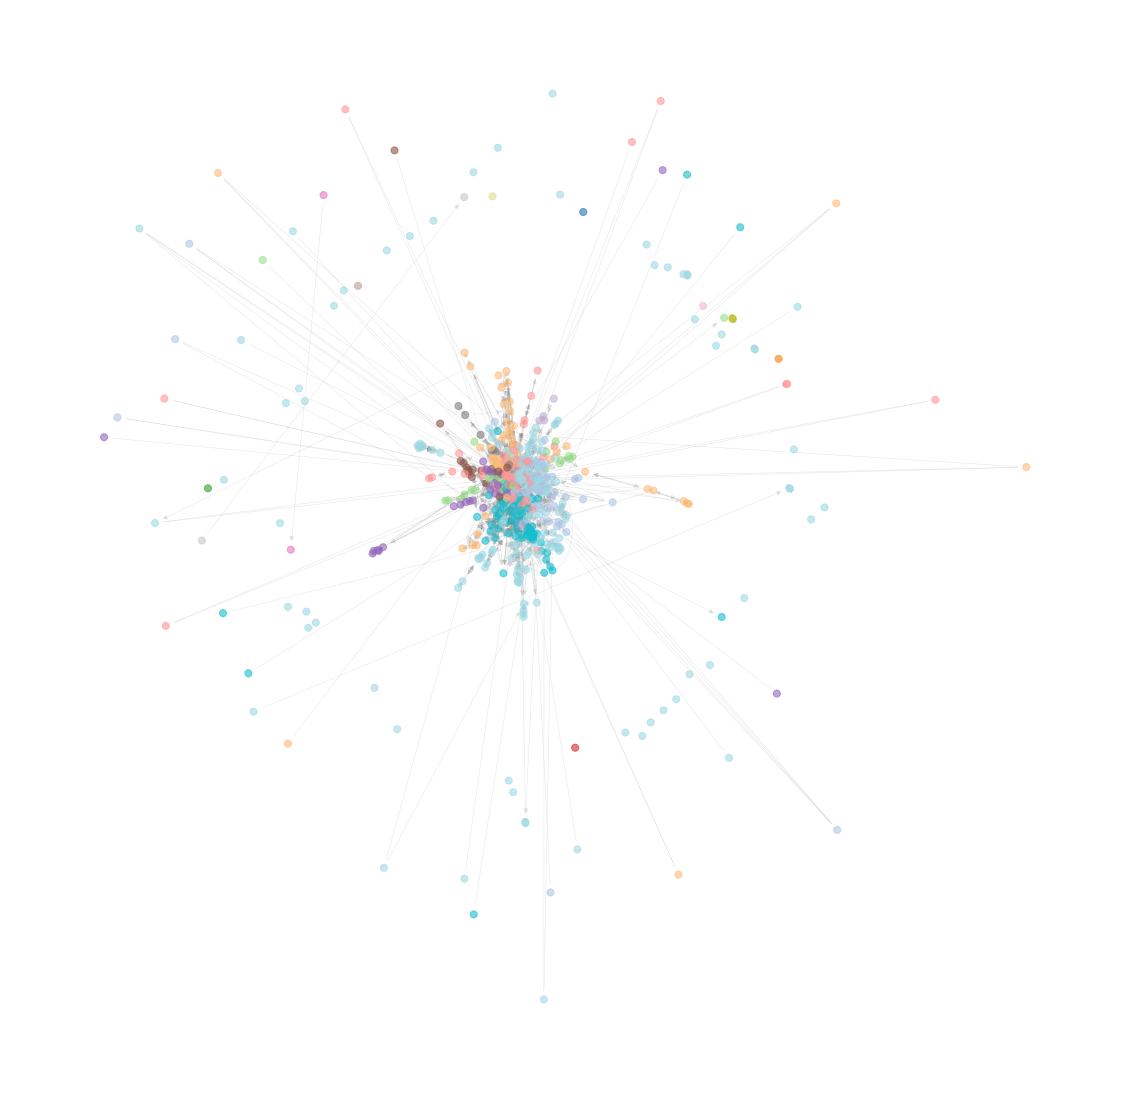

In [12]:
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1,

                        # Log
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

fig, ax = plt.subplots(figsize=(20,20))

nx.draw_networkx_nodes(G,pos=pos, node_color=node_color_list, node_size=50, alpha=0.6)
nx.draw_networkx_edges(G,pos=pos, edge_color = 'gray', width=0.5, alpha=0.2)

plt.axis('off')
plt.show()